# Example 1: pyVDERM quick start guide
Import an object, assign a density field, run a deformation, plot, remesh, and export the results

In [9]:
import pyVDERM as vd
import numpy as np

### Import a mesh file and create a point cloud

In [10]:
points, norms = vd.create_pcd('cube.stl',n_pts=10_000)


### Create an underlying grid for the object
By default, make_initial_grid will aim to leave padding equal to the size of the object on each side of the object, so that the grid dimensions are 3x the object dimensions. The padding argument can be used to change this ratio (see 02_BoundaryConditions)

In [11]:
grid_params = vd.make_initial_grid(points,max_points=32_000)

In [12]:
vd.print_grid_info(grid_params)

GRID INFORMATION

Grid dimensions: 32 × 32 × 32 = 32,768 points
Grid spacing (h): 0.355476

Grid size:   [11.0198, 11.0198, 11.0198]
Object size: [5.5099, 5.5099, 5.5099]
Ratio:       [2.00x, 2.00x, 2.00x]

Grid bounds:
  x: [-5.5099, 5.5099]
  y: [-5.5099, 5.5099]
  z: [-5.5099, 5.5099]

Object bounds:
  x: [-2.7549, 2.7549]
  y: [-2.7549, 2.7549]
  z: [-2.7549, 2.7549]

Object margins (distance from grid boundary):
  x: min=2.7549, max=2.7549
  y: min=2.7549, max=2.7549
  z: min=2.7549, max=2.7549

Verification for padding ratios:
  x: 2.000x
  y: 2.000x
  z: 2.000x


### Set density
The set_density method of the vdermGRID object can accept either a density function, or an array of densities. The density function must take as argumnts the x, y, and z positions. A density array must have the same shape as the underlying grid. For more detail on density fields, see 03_DensityFields

In [13]:
# option 1: set density with a position function
def periodic_density(x,y,z):
    # a density function can reference the grid parameters
    L = grid_params['shape'][0]
    return 10 + 9.99*np.sin(8*32/L*np.pi*x/(L-1))*np.cos(4*32/L*np.pi*y/(L-1))*np.cos(4*32/L*np.pi*z/(L-1))

# option 2: set density directly with an array
L, M, N = 32, 32, 32
rho_0 = np.zeros(shape=(L,M,N))
for i in range(L):
    for j in range(M):
        for k in range(N):
            rho_0[i,j,k] = 10 + 9.99*np.sin(8*np.pi*i/(L-1))*np.cos(4*np.pi*j/(M-1))*np.cos(4*np.pi*k/(N-1))

In [14]:
# make the grid
vdgrid = vd.VDERMGrid(shape=grid_params['shape'],h=grid_params['h'],min_bounds=grid_params['min_bounds'])
# add the densities 
vdgrid.set_density(rho_0)
# uncomment the next line to set density with the function instead of the array
# vdgrid.set_density(periodic_density)

### Run the deformation

In [15]:
deformed_grid = vd.run_VDERM(vdgrid, n_max=100)

Deforming: 100%|██████████| 100/100 [00:25<00:00,  3.90it/s, ε=2.275e-01, target=1.000e-02]


### Deform again if needed
The vdermGRID object is updated with each iteration, so multiple deforms can be run sequentially on the same object. The algorithm will converge at a default value of epsilon = 0.01, which can be changed with the max_eps parameter in run_VDERM

In [16]:
second_deformation = vd.run_VDERM(vdgrid, n_max=1000)

Converged:  12%|█▏        | 119/1000 [00:32<03:57,  3.71it/s, ε=9.961e-03, target=1.000e-02]


Converged at iteration 119


### Plot the results 
The plot_pcd function plots any 3D point cloud, colored by density. Often it is desirable to save a copy of the initial densities and use these for plotting, since the densities will equalize throughout the deformation. Setting view to '2d' will plot a view of each plane. Setting the view to '3d' will plot a 3D scatterplot

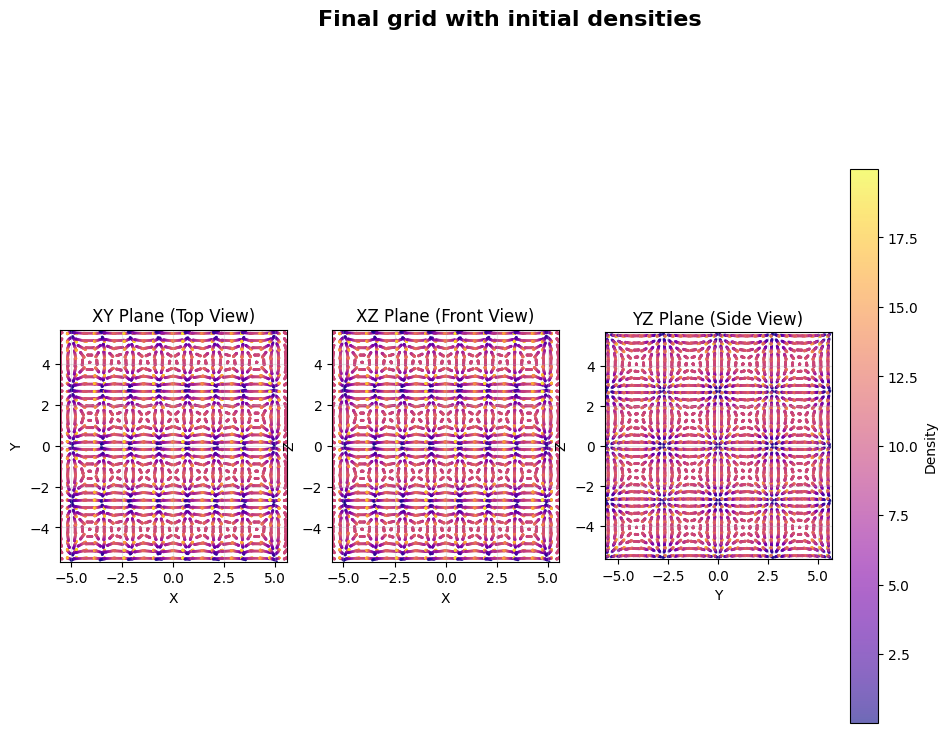

In [17]:
densities_flat = rho_0.ravel()
positions_final = vdgrid.positions
fig = vd.plot_pcd(positions_final,densities_flat,view='2d',title='Final grid with initial densities')

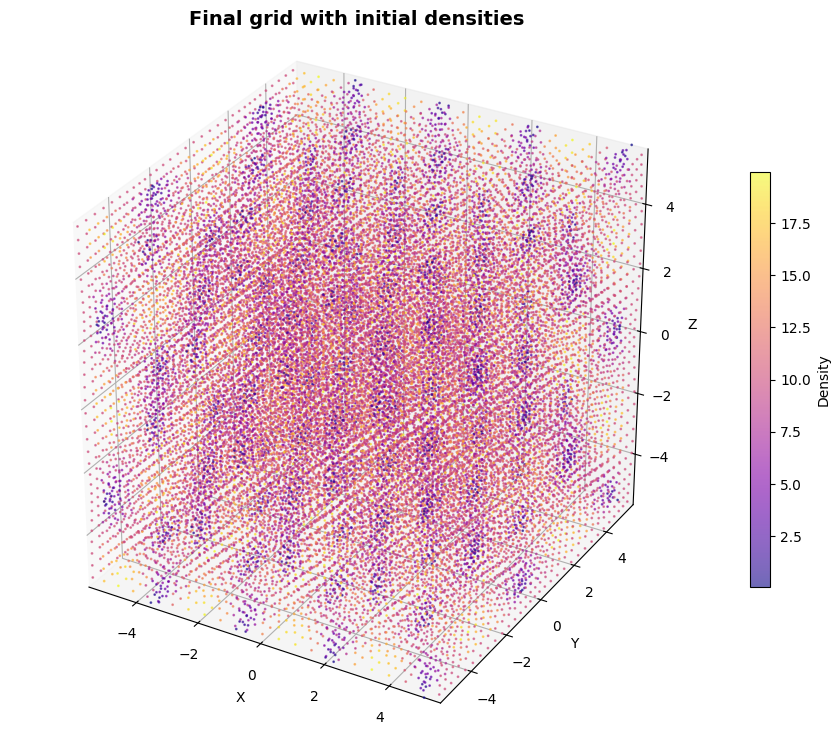

In [18]:
fig = vd.plot_pcd(positions_final,densities_flat,view='3d',title='Final grid with initial densities')

### Apply the deformation to the object
The deformation can now be applied to teh initial surface point cloud by interpolating the vector field generated by the underlying grid. The density field can also be interpolated to the surface

In [19]:
deformed_surface = vd.interpolate_to_surface(points, grid_params, deformed_grid.get_displacement_field())
interpolated_densities = vd.interpolate_densities(points,vdgrid)

### Plot and save the deformed surface
To view the cube with the initial densities, as shown on the grid above, create a new vderm grid object with the same grid parameters and initial densities. Then pass that grid into the interpolate densities function with the deformed point cloud.

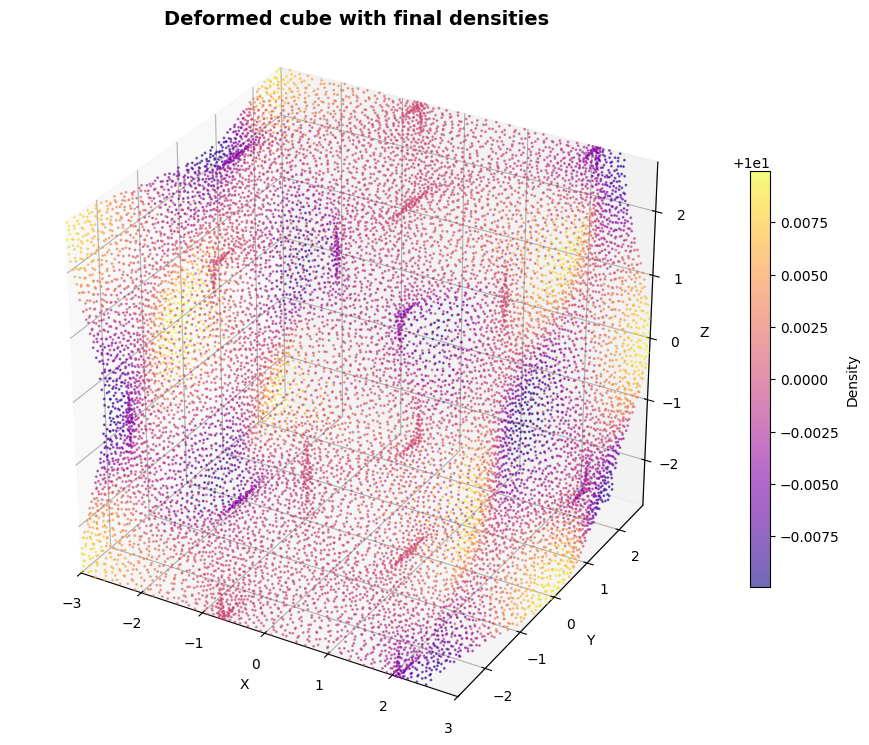

In [20]:
fig = vd.plot_pcd(deformed_surface,interpolated_densities,view='3d',title='Deformed cube with final densities')

In [13]:
vd.export_mesh_file('deformed_cube.stl', deformed_surface)